<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

Código básico de importación y funciones de graficación (no modificar)

In [43]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Instalamos Gym

In [44]:
!pip install gymnasium
import gymnasium as gym


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\tania\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

El uso de una política $\epsilon$-greedy es una estrategia común en el aprendizaje por refuerzo, ya que permite que el agente explore nuevas acciones mientras explota las acciones que se consideran las mejores hasta ese momento. El valor de $\epsilon$ determina cuánta exploración realiza el agente. A medida que $\epsilon$ disminuye, la política se vuelve más determinista y el agente tiende a explotar más que explorar. Por otro lado, un valor alto de $\epsilon$ resulta en más exploración. El equilibrio entre exploración y explotación es crucial para que el agente aprenda y tome decisiones efectivas.






In [45]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    # 1. Obtener los valores Q para todas las acciones en el estado actual
    q_values = [q.get((state, a), 0.0) for a in actions]
    # 2. Encontrar la acción con el valor Q máximo
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    # 3. Implementar la política épsilon-greedy

    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [46]:
def learn_SARSA(
        state: Any,
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: dict,
        q: dict,
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: Estado actual
        action: Acción tomada en el estado actual
        reward: Recompensa obtenida al realizar la acción
        next_state: Siguiente estado tras la acción
        next_action: Próxima acción a tomar
        hyperparameters: Hiperparámetros del agente (por ejemplo, tasa de aprendizaje)
        q: Diccionario de valores Q (estado-acción)
    """

    # Obtenemos los hiperparámetros relevantes
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Obtenemos el valor Q actual para el par estado-acción actual
    q_current = q.get((state, action), 0.0)

    # Obtenemos el valor Q para el par estado-acción siguiente
    q_next = q.get((next_state, next_action), 0.0)

    # Calculamos la actualización SARSA
    updated_q = q_current + alpha * (reward + gamma * q_next - q_current)

    # Actualizamos el valor Q en el diccionario de valores Q
    q[(state, action)] = updated_q
pass

In [47]:
def learn_Q_learning(
        state: Any,
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: dict,
        q: dict,
) -> None:

    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args:
        state: El estado actual.
        action: La acción tomada en el estado actual.
        reward: La recompensa recibida por tomar la acción en el estado actual.
        next_state: El siguiente estado resultante de tomar la acción.
        next_action: La próxima acción seleccionada en el siguiente estado (según la política utilizada).
        hyperparameters: Un diccionario que contiene hiperparámetros (por ejemplo, alpha, gamma).
        q: Un diccionario que almacena los valores Q, que se actualizará con la nueva estimación.
    """

        # Desempaquetar los hiperparámetros
    alpha = hyperparameters['alpha']  # Tasa de aprendizaje
    gamma = hyperparameters['gamma']  # Factor de descuento

    # Calcular el valor Q actual para el estado-acción actual
    current_q_value = q.get((state, action), 0.0)

    # Calcular el valor Q del mejor estado-acción futuro (Q máximo)
    next_q_values = [q.get((next_state, a), 0.0) for a in actions]
    max_next_q_value = max(next_q_values)

    # Aplicar la fórmula de actualización Q-learning
    new_q_value = current_q_value + alpha * (reward + gamma * max_next_q_value - current_q_value)

    # Actualizar el valor Q en el diccionario q
    q[(state, action)] = new_q_value

    pass


Finalmente, definimos el método principal de iteraciones.

In [48]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [49]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [50]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

### Análisis de la ejecución del agente

#### Análisis de convergencia

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

Aqui debajo estan los graficos para SARSA en épsilon-greedy. Para Q-learning, se debe cambiar en learning_function = learn_SARSA por learning_function = learn_Q_learning, arriba. 
Para comparar ambos metodos pusimos los gráficos de SARSA y Q-learning en un PDF en el repo llamado "Comparacion gráficos épsilon-greedy"

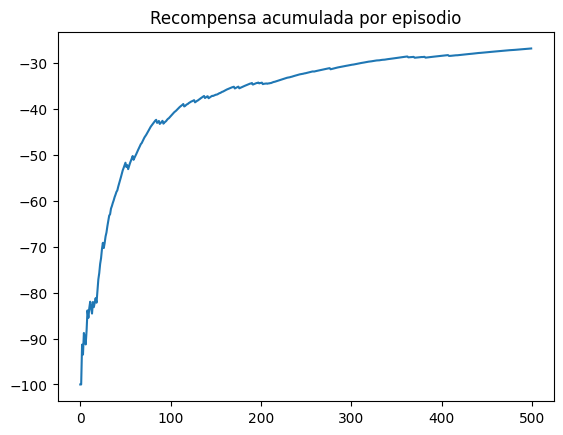

In [51]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

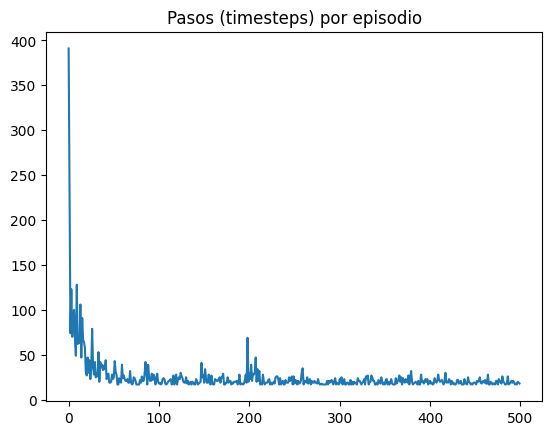

In [52]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

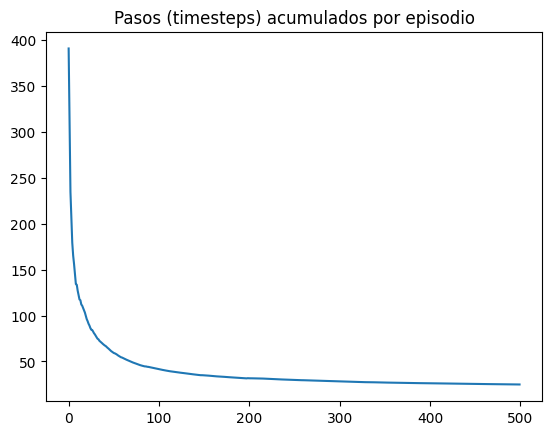

In [53]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

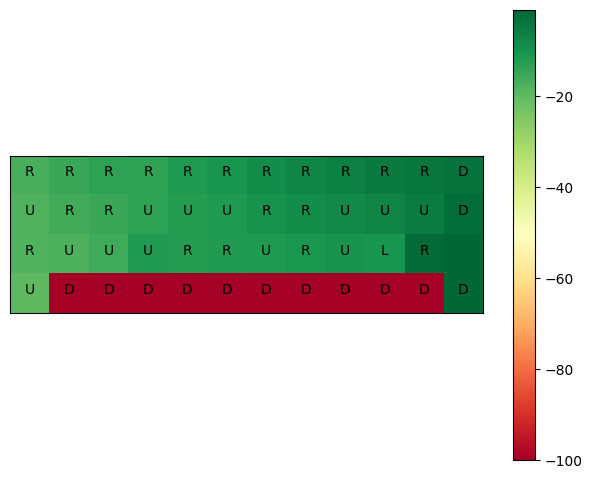


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [54]:
draw_value_matrix(q)

In [55]:
env.close()

# Cómo converge Q-Learning con respecto a SARSA? 
VER GRÁFICOS COMPARATIVOS EN EL PDF "Comparacion gráficos épsilon-greedy"

En la comparación entre los algoritmos SARSA y Q-Learning usando una política epsilon-greedy a través de gráficos, hemos llegado a la conclusión de que SARSA demuestra un rendimiento superior. Las razones de esta preferencias son: 

En primer lugar, SARSA mostró una mayor velocidad de convergencia. Además, SARSA fue más estable durante el proceso de entrenamiento, lo que significa que su rendimiento no fluctuó tanto como el de Q-Learning. 

SARSA logró una recompensa acumulada más alta en comparación con Q-Learning. Esto sugiere que SARSA pudo encontrar una estrategia más efectiva para obtener recompensas en el entorno "The Cliff".


# Ejecutando con distintos híper-parámetros, realizamos una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

Aqui debajo vamos a ir probando diferentes combinaciones de hiperparametros para ver que sucede. Los graficos los dejamos en un PDF en el Repositorio llamado "Ajuste de hiperparametros"

In [126]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.05,
    "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [127]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

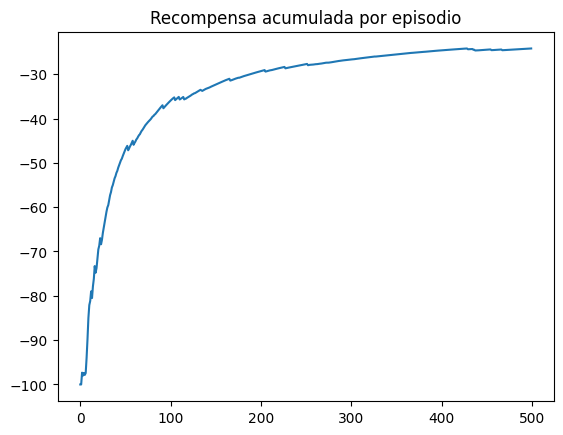

In [128]:
plot_reward_per_episode(reward_ep)

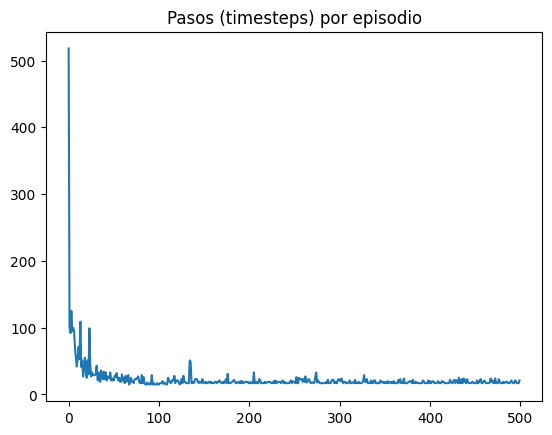

In [129]:
plot_steps_per_episode(timesteps_ep)

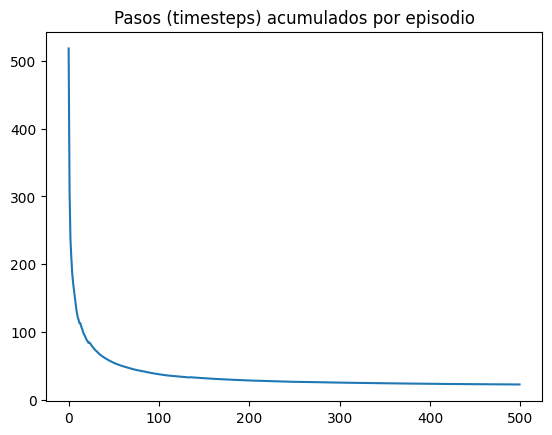

In [130]:
plot_steps_per_episode_smooth(timesteps_ep)

Despues del analisis con distintos hiperparámetros, nos quedamos con la versión original con los hiperparámetros:

    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,


# El ejercicio 4 implementando la política de exploración Softmax, está en una notebook aparte llamada "implementando_softmax"